In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Supplemental Figure 7 of the nanoCOP manuscript. 

This script requires the datasets produced in the script nanoCOP_intron_pairs_datasets.ipynb
                                            

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math
from random import shuffle

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")

import itertools

import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

In [2]:
def get_all_multi_intron_lengths(read_junctions, intron_min):

    multi_introns = []

    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if ((len(read_junctions[read][gene]) >= intron_min) & (len(read_junctions[read][gene]) <= 10)):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    temp = [] 

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)
                    
                    dif = (np.max(read_introns_df['intron_count'])-np.min(read_introns_df['intron_count'])+1)
                    if (len(read_introns_df)==dif):

                        for i in range(len(read_introns_df)):
                            intron_count = read_introns_df.iloc[i]['intron_count']
                            intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                            intron_start = str(read_introns_df.iloc[i]['start'])
                            intron_end = str(read_introns_df.iloc[i]['end'])
                            intron_strand = read_introns_df.iloc[i]['strand']
                            intron_splice = read_introns_df.iloc[i]['splice_status']
                            intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end
                            intron_length = int(intron_end)-int(intron_start)

                            temp.append(intron_length)


                        if (intron_strand=='+'):

                            final = []
                            final.append(read)
                            final.append(gene)
                            final.append(intron_strand)

                            for i in temp:
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_')

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)


                        if (intron_strand=='-'):

                            final = []
                            final.append(read)
                            final.append(gene)
                            final.append(intron_strand)

                            for i in reversed(temp):
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_') 

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)
                                

    multi_introns_df = pd.DataFrame(multi_introns)
    multi_introns_df.columns = ['read','gene','strand','int1','int2','int3','int4','int5','int6','int7','int8','int9','int10']
    multi_introns_df = multi_introns_df.sort_values(by=['read']).reset_index(drop=True)

    return multi_introns_df


# function to label missing gene names with transcript names
def name_missing_genes(row):
    if pd.isnull(row['gene']):
        return (row['transcript'])

    else:
        return (row['gene'])




In [24]:
# upload file with information about all introns in hg38 or dmel6
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
hg38_intron_info = hg38_intron_info[['chrom','start','end','name','intron_length','strand']]
hg38_intron_info = hg38_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')
dm6_intron_info = dm6_intron_info[['chrom','start','end','name','intron_length','strand']]
dm6_intron_info = dm6_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)


In [43]:
# open dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = np.load('/path/to/K562_1_splicing_dictionary.npy').item() 
K562_2_splice_dictionary = np.load('/path/to/K562_2_splicing_dictionary.npy').item() 
K562_3_splice_dictionary = np.load('/path/to/K562_3_splicing_dictionary.npy').item() 
K562_4_splice_dictionary = np.load('/path/to/K562_4_splicing_dictionary.npy').item() 
K562_5a_splice_dictionary = np.load('/path/to/K562_5a_splicing_dictionary.npy').item() 
K562_5b_splice_dictionary = np.load('/path/to/K562_5b_splicing_dictionary.npy').item() 

S2_1a_splice_dictionary = np.load('/path/to/S2_1a_splicing_dictionary.npy').item() 
S2_1b_splice_dictionary = np.load('/path/to/S2_1b_splicing_dictionary.npy').item() 
S2_2_splice_dictionary = np.load('/path/to/S2_2_splicing_dictionary.npy').item() 
S2_3_splice_dictionary = np.load('/path/to/S2_3_splicing_dictionary.npy').item() 


In [28]:
# get multi intron df for K562
K562_1_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_1_splice_dictionary, 3)
K562_2_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_2_splice_dictionary, 3)
K562_3_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_3_splice_dictionary, 3)
K562_4_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_4_splice_dictionary, 3)
K562_5a_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_5a_splice_dictionary, 3)
K562_5b_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_5b_splice_dictionary, 3)

# get multi intron df for S2
S2_1a_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_1a_splice_dictionary, 3)
S2_1b_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_1b_splice_dictionary, 3)
S2_2_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_2_splice_dictionary, 3)
S2_3_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_3_splice_dictionary, 3)

K562_intron_lengths = pd.concat([K562_1_multi_intron_lengths_df,K562_2_multi_intron_lengths_df,K562_3_multi_intron_lengths_df,K562_4_multi_intron_lengths_df,K562_5a_multi_intron_lengths_df,K562_5b_multi_intron_lengths_df])
S2_intron_lengths = pd.concat([S2_1a_multi_intron_lengths_df,S2_1b_multi_intron_lengths_df,S2_2_multi_intron_lengths_df,S2_3_multi_intron_lengths_df])


In [31]:
# add min and max to match all introns (human)
K562_intron1 = K562_intron_lengths['int1'].append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron1 = K562_intron_lengths['int1'].append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

K562_intron2 = K562_intron_lengths['int2'].append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron2 = K562_intron_lengths['int2'].append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

K562_intron3 = K562_intron_lengths['int3'].append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron3 = K562_intron_lengths['int3'].append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

# add min and max to match all introns (Drosophila)
S2_intron1 = S2_intron_lengths['int1'].append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron1 = S2_intron_lengths['int1'].append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))

S2_intron2 = S2_intron_lengths['int2'].append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron2 = S2_intron_lengths['int2'].append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))

S2_intron3 = S2_intron_lengths['int3'].append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron3 = S2_intron_lengths['int3'].append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))


In [34]:
# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
genes_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_genes_parsed.bed',header=None)
genes_df = genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
genes_df['gene_length'] = genes_df['end']-genes_df['start']
genes_df['transcript'] = genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
genes_df = genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
names_df = pd.read_table('/path/to/annotation_files/hg38_UCSC_refGene_names.txt', header=None)
names_df.columns = ['gene','transcript']

genes_names_merge = pd.merge(genes_df, names_df, on=['transcript'], how='left')
genes_names_merge['gene'] = genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
genes_names_merge = genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
genes_names_merge = genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

genes_names_merge = genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)

# create a bed file for all unique genes
gene_bed = BedTool.from_dataframe(genes_names_merge)


K562_bamFile = pybedtools.BedTool('/path/to/all_K562_hg38_minimap2_uniq_sort.bam')
K562_bedFile = K562_bamFile.bam_to_bed()

K562_coverage = gene_bed.coverage(K562_bedFile, s=True, counts=True) 
K562_df = K562_coverage.to_dataframe() # covert to dataframe
K562_df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
K562_df = K562_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords


In [35]:
K562_genes = K562_df.copy()

K562_genes['expression'] = K562_genes['count']/(K562_genes['end']-K562_genes['start'])
K562_genes = K562_genes[K562_genes['expression']>K562_genes['expression'].quantile(q=0.9)].reset_index(drop=True)

hg38_introns = hg38_intron_info.copy()
hg38_introns['gene'] = hg38_introns.apply(lambda row: str(row['name'].split("_")[0])+'_'+str(row['name'].split("_")[1].split(".")[0]) , axis=1)

K562_introns = hg38_introns[hg38_introns.apply(lambda row: row['gene'] in set(K562_genes['transcript']) , axis=1)].reset_index(drop=True)

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


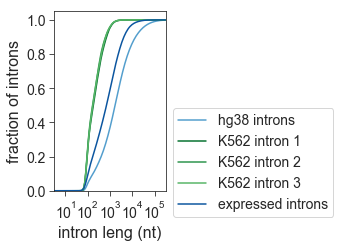

In [36]:

fig, ax = plt.subplots(figsize=(2,3.3))

hg38_intron_lengths = np.log10(hg38_intron_info['intron_length'].values)
K562_intron1_lengths = np.log10(K562_intron1.values)
K562_intron2_lengths = np.log10(K562_intron2.values)
K562_intron3_lengths = np.log10(K562_intron3.values)
K562_introns_expr_lengths = np.log10(K562_introns['intron_length'].values)

ax = sns.distplot(hg38_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(hg38_intron_info['intron_length']), label='hg38 introns')
sns.distplot(K562_intron1_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(hg38_intron_info['intron_length']), label='K562 intron 1')
sns.distplot(K562_intron2_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[4], bins=np.max(hg38_intron_info['intron_length']), label='K562 intron 2')
sns.distplot(K562_intron3_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(hg38_intron_info['intron_length']), label='K562 intron 3')
sns.distplot(K562_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron leng (nt)", fontsize=16)
ax.legend(bbox_to_anchor=[1,0.5], fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_7A_K562_triplets_intron_length_cumdist_plot_withExpressedIntrons.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [50]:
# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
genes_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_genes_parsed.bed',header=None)
genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
genes_df['chrom'] = "chr"+genes_df['chrom']
genes_df['gene_length'] = genes_df['end']-genes_df['start']
genes_df['transcript'] = genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
genes_df = genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
names_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_names_parsed.txt', header=None)
names_df.columns = ['gene','transcript']

genes_names_merge = pd.merge(genes_df, names_df, on=['transcript'], how='left')
genes_names_merge['gene'] = genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
genes_names_merge = genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
genes_names_merge = genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

genes_names_merge = genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)

# create a bed file for all unique genes
gene_bed = BedTool.from_dataframe(genes_names_merge)



In [51]:
# get K562 ONT coverage information for both replicates
S2_bamFile = pybedtools.BedTool('/path/to/all_S2_180420_dmel6_minimap2_uniq_sort.bam')

S2_bedFile = S2_bamFile.bam_to_bed()

# get number of reads that overlap each gene feature
S2_coverage = gene_bed.coverage(S2_bedFile, s=True, counts=True) 

# make a dataframe from coverage file
S2_df = S2_coverage.to_dataframe() # covert to dataframe
S2_df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
S2_df = S2_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords


In [52]:
S2_genes = S2_df.copy()

S2_genes['expression'] = S2_genes['count']/(S2_genes['end']-S2_genes['start'])
S2_genes = S2_genes[S2_genes['expression']>S2_genes['expression'].quantile(q=0.9)].reset_index(drop=True)

dm6_introns = dm6_intron_info.copy()
dm6_introns['gene'] = dm6_introns.apply(lambda row: str(row['name'].split("_")[0])+'_'+str(row['name'].split("_")[1].split(".")[0]) , axis=1)

S2_introns = dm6_introns[dm6_introns.apply(lambda row: row['gene'] in set(S2_genes['transcript']) , axis=1)].reset_index(drop=True)

In [53]:
len(S2_introns)

3056

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


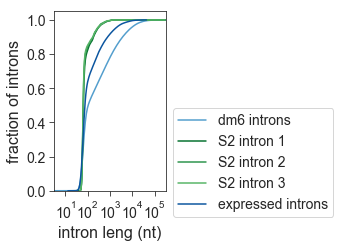

In [54]:

fig, ax = plt.subplots(figsize=(2,3.3))

dm6_intron_lengths = np.log10(dm6_intron_info['intron_length'].values)
S2_intron1_lengths = np.log10(S2_intron1.values)
S2_intron2_lengths = np.log10(S2_intron2.values)
S2_intron3_lengths = np.log10(S2_intron3.values)
S2_introns_expr_lengths = np.log10(S2_introns['intron_length'].values)

ax = sns.distplot(dm6_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(dm6_intron_info['intron_length']), label='dm6 introns')
sns.distplot(S2_intron1_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(dm6_intron_info['intron_length']), label='S2 intron 1')
sns.distplot(S2_intron2_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[4], bins=np.max(dm6_intron_info['intron_length']), label='S2 intron 2')
sns.distplot(S2_intron3_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(dm6_intron_info['intron_length']), label='S2 intron 3')
sns.distplot(S2_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron leng (nt)", fontsize=16)
ax.legend(bbox_to_anchor=[1,0.5], fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_7A_S2_triplets_intron_length_cumdist_plot_withExpressedIntrons.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [38]:
# Supplementary Figure 7B
# get multi intron df for K562
K562_1_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_1_splice_dictionary, 4)
K562_2_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_2_splice_dictionary, 4)
K562_3_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_3_splice_dictionary, 4)
K562_4_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_4_splice_dictionary, 4)
K562_5a_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_5a_splice_dictionary, 4)
K562_5b_multi_intron_lengths_df = get_all_multi_intron_lengths(K562_5b_splice_dictionary, 4)


In [39]:
# get multi intron df for S2
S2_1a_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_1a_splice_dictionary, 4)
S2_1b_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_1b_splice_dictionary, 4)
S2_2_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_2_splice_dictionary, 4)
S2_3_multi_intron_lengths_df = get_all_multi_intron_lengths(S2_3_splice_dictionary, 4)


In [40]:
K562_intron_lengths = pd.concat([K562_1_multi_intron_lengths_df,K562_2_multi_intron_lengths_df,K562_3_multi_intron_lengths_df,K562_4_multi_intron_lengths_df,K562_5a_multi_intron_lengths_df,K562_5b_multi_intron_lengths_df])
S2_intron_lengths = pd.concat([S2_1a_multi_intron_lengths_df,S2_1b_multi_intron_lengths_df,S2_2_multi_intron_lengths_df,S2_3_multi_intron_lengths_df])


In [41]:
# add min and max to match all introns (human)
K562_intron1 = K562_intron_lengths['int1'].append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron1 = K562_intron_lengths['int1'].append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

K562_intron2 = K562_intron_lengths['int2'].append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron2 = K562_intron_lengths['int2'].append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

K562_intron3 = K562_intron_lengths['int3'].append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron3 = K562_intron_lengths['int3'].append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

K562_intron4 = K562_intron_lengths['int4'].append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron4 = K562_intron_lengths['int4'].append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

# add min and max to match all introns (Drosophila)
S2_intron1 = S2_intron_lengths['int1'].append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron1 = S2_intron_lengths['int1'].append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))

S2_intron2 = S2_intron_lengths['int2'].append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron2 = S2_intron_lengths['int2'].append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))

S2_intron3 = S2_intron_lengths['int3'].append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron3 = S2_intron_lengths['int3'].append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))

S2_intron4 = S2_intron_lengths['int4'].append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron4 = S2_intron_lengths['int4'].append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


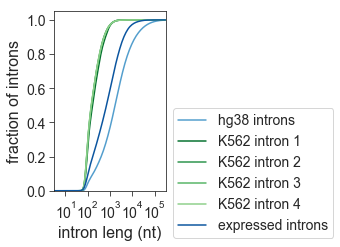

In [43]:

fig, ax = plt.subplots(figsize=(2,3.3))

hg38_intron_lengths = np.log10(hg38_intron_info['intron_length'].values)
K562_intron1_lengths = np.log10(K562_intron1.values)
K562_intron2_lengths = np.log10(K562_intron2.values)
K562_intron3_lengths = np.log10(K562_intron3.values)
K562_intron4_lengths = np.log10(K562_intron4.values)
K562_introns_expr_lengths = np.log10(K562_introns['intron_length'].values)

ax = sns.distplot(hg38_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(hg38_intron_info['intron_length']), label='hg38 introns')
sns.distplot(K562_intron1_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(hg38_intron_info['intron_length']), label='K562 intron 1')
sns.distplot(K562_intron2_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[4], bins=np.max(hg38_intron_info['intron_length']), label='K562 intron 2')
sns.distplot(K562_intron3_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(hg38_intron_info['intron_length']), label='K562 intron 3')
sns.distplot(K562_intron4_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[2], bins=np.max(hg38_intron_info['intron_length']), label='K562 intron 4')
sns.distplot(K562_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron leng (nt)", fontsize=16)
ax.legend(bbox_to_anchor=[1,0.5], fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_7B_K562_quads_intron_length_cumdist_plot_withExpressedIntrons.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


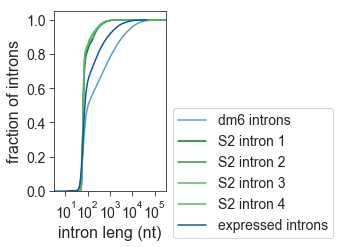

In [55]:

fig, ax = plt.subplots(figsize=(2,3.3))

dm6_intron_lengths = np.log10(dm6_intron_info['intron_length'].values)
S2_intron1_lengths = np.log10(S2_intron1.values)
S2_intron2_lengths = np.log10(S2_intron2.values)
S2_intron3_lengths = np.log10(S2_intron3.values)
S2_intron4_lengths = np.log10(S2_intron4.values)
S2_introns_expr_lengths = np.log10(S2_introns['intron_length'].values)

ax = sns.distplot(dm6_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(dm6_intron_info['intron_length']), label='dm6 introns')
sns.distplot(S2_intron1_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(dm6_intron_info['intron_length']), label='S2 intron 1')
sns.distplot(S2_intron2_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[4], bins=np.max(dm6_intron_info['intron_length']), label='S2 intron 2')
sns.distplot(S2_intron3_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(dm6_intron_info['intron_length']), label='S2 intron 3')
sns.distplot(S2_intron4_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(dm6_intron_info['intron_length']), label='S2 intron 4')
sns.distplot(S2_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')


x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron leng (nt)", fontsize=16)
ax.legend(bbox_to_anchor=[1,0.5], fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_7B_S2_quads_intron_length_cumdist_plot_withExpressedIntrons.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [6]:
# get multi intron df for K562
K562_1_multi_introns_df = get_all_multi_introns(K562_1_splice_dictionary, 3)
K562_2_multi_introns_df = get_all_multi_introns(K562_2_splice_dictionary, 3)
K562_3_multi_introns_df = get_all_multi_introns(K562_3_splice_dictionary, 3)
K562_4_multi_introns_df = get_all_multi_introns(K562_4_splice_dictionary, 3)
K562_5a_multi_introns_df = get_all_multi_introns(K562_5a_splice_dictionary, 3)
K562_5b_multi_introns_df = get_all_multi_introns(K562_5b_splice_dictionary, 3)


In [7]:
# get multi intron df for S2
S2_1a_multi_introns_df = get_all_multi_introns(S2_1a_splice_dictionary, 3)
S2_1b_multi_introns_df = get_all_multi_introns(S2_1b_splice_dictionary, 3)
S2_2_multi_introns_df = get_all_multi_introns(S2_2_splice_dictionary, 3)
S2_3_multi_introns_df = get_all_multi_introns(S2_3_splice_dictionary, 3)


In [ ]:
### Supplmemenatl Figure 7C-D

In [4]:
def get_intron_position_dictionaries(intron_info):
    
    first_intron_info = intron_info[intron_info['intron_order']=='first']
    first_intron_info = first_intron_info[['gene','count']]
    first_intron_info = first_intron_info.set_index('gene')['count'].to_dict()

    last_intron_info = intron_info[intron_info['intron_order']=='last']
    last_intron_info = last_intron_info[['gene','count']]
    last_intron_info = last_intron_info.set_index('gene')['count'].to_dict()

    return first_intron_info, last_intron_info


def get_all_multi_introns(read_junctions, intron_min, first_intron_info, last_intron_info):

    multi_introns = []

    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if ((len(read_junctions[read][gene]) >= intron_min) & (len(read_junctions[read][gene]) <= 10)):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    temp = [] 

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                    dif = (np.max(read_introns_df['intron_count'])-np.min(read_introns_df['intron_count'])+1)
                    if (len(read_introns_df)==dif):

                        for i in range(len(read_introns_df)):
                            intron_count = read_introns_df.iloc[i]['intron_count']
                            intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                            intron_start = str(read_introns_df.iloc[i]['start'])
                            intron_end = str(read_introns_df.iloc[i]['end'])
                            intron_strand = read_introns_df.iloc[i]['strand']
                            intron_splice = read_introns_df.iloc[i]['splice_status']
                            intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                            if ((first_intron_info[gene]!=intron_count) & (last_intron_info[gene]!=intron_count)):
                                temp.append(intron_splice)


                        if (intron_strand=='+'):

                            final = []
                            final.append(read)
                            final.append(intron_strand)

                            for i in temp:
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_')

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)


                        if (intron_strand=='-'):

                            final = []
                            final.append(read)
                            final.append(intron_strand)

                            for i in reversed(temp):
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_') 

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)

    multi_introns_df = pd.DataFrame(multi_introns)
    multi_introns_df.columns = ['read','strand','int1','int2','int3','int4','int5','int6','int7','int8','int9','int10']
    multi_introns_df = multi_introns_df.sort_values(by=['read']).reset_index(drop=True)

    return multi_introns_df


def get_intron_quads_df(read_junctions):
    intron_quads = []

    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) >= 4):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    # loop through all triplets within a read
                    for i in range(len(splice_status)-2):

                        # loop through all triplets within a read
                        if ((splice_status[i]!=splice_status[i+1]) or (splice_status[i]!=splice_status[i+2]) or (splice_status[i]!=splice_status[i+3])):
                            temp = []

                            # build a dataframe of introns in the gene that map to this read
                            # and are capable of being sequenced if the read has no splicing
                            read_introns_df = pd.DataFrame(read_junctions[read][gene])[i:i+3]
                            read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                            read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                            dif = (np.max(read_introns_df['intron_count'])-np.min(read_introns_df['intron_count'])+1)
                            if (len(read_introns_df)==3) & (len(read_introns_df)==dif):

                                for j in range(len(read_introns_df)):
                                    intron_count = read_introns_df.iloc[j]['intron_count']
                                    intron_chrom = str(read_introns_df.iloc[j]['chrom'])
                                    intron_start = str(read_introns_df.iloc[j]['start'])
                                    intron_end = str(read_introns_df.iloc[j]['end'])
                                    intron_strand = read_introns_df.iloc[j]['strand']
                                    intron_splice = read_introns_df.iloc[j]['splice_status']
                                    intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                                    temp.append(intron_splice)

                                if (intron_strand=='+'):

                                    final = []
                                    final.append(read)
                                    final.append(intron_strand)

                                    for i in temp:
                                        final.append(i)

                                    if ((len(final)==6) & (final.count('YES')>=1) & (final.count('NO')>=1)):
                                        intron_quads.append(final)


                                if (intron_strand=='-'):

                                    final = []
                                    final.append(read)
                                    final.append(intron_strand)

                                    for i in reversed(temp):
                                        final.append(i)

                                    if ((len(final)==6) & (final.count('YES')>=1) & (final.count('NO')>=1)):
                                        intron_quads.append(final)

    intron_quads_df = pd.DataFrame(intron_quads)
    intron_quads_df.columns = ['read','strand','int1','int2','int3','int4']

    return intron_quads_df




def get_triplet_splicing_order(intron_triplets_df):
    
    triplet_order = []
    
    triplet_order.append(['YES_NO_NO', np.round(len(intron_triplets_df[(intron_triplets_df['int1']=='YES') & (intron_triplets_df['int2']=='NO') & (intron_triplets_df['int3']=='NO')])/float(len(intron_triplets_df))*100, 1)])
    triplet_order.append(['NO_YES_NO', np.round(len(intron_triplets_df[(intron_triplets_df['int1']=='NO') & (intron_triplets_df['int2']=='YES') & (intron_triplets_df['int3']=='NO')])/float(len(intron_triplets_df))*100, 1)])
    triplet_order.append(['NO_NO_YES', np.round(len(intron_triplets_df[(intron_triplets_df['int1']=='NO') & (intron_triplets_df['int2']=='NO') & (intron_triplets_df['int3']=='YES')])/float(len(intron_triplets_df))*100, 1)])

    triplet_order.append(['YES_YES_NO', np.round(len(intron_triplets_df[(intron_triplets_df['int1']=='YES') & (intron_triplets_df['int2']=='YES') & (intron_triplets_df['int3']=='NO')])/float(len(intron_triplets_df))*100, 1)])
    triplet_order.append(['YES_NO_YES', np.round(len(intron_triplets_df[(intron_triplets_df['int1']=='YES') & (intron_triplets_df['int2']=='NO') & (intron_triplets_df['int3']=='YES')])/float(len(intron_triplets_df))*100, 1)])
    triplet_order.append(['NO_YES_YES', np.round(len(intron_triplets_df[(intron_triplets_df['int1']=='NO') & (intron_triplets_df['int2']=='YES') & (intron_triplets_df['int3']=='YES')])/float(len(intron_triplets_df))*100, 1)])

    triplet_order_df = pd.DataFrame(triplet_order)
    triplet_order_df.columns = ['splicing_status','freq']
    
    return triplet_order_df


def get_triplet_splicing_order_split(intron_triplets_df):
    
    triplet_order_1spliced = []
    triplet_order_2spliced = []

    triplet_order_1spliced.append(['YES_NO_NO', len(intron_triplets_df[(intron_triplets_df['int1']=='YES') & (intron_triplets_df['int2']=='NO') & (intron_triplets_df['int3']=='NO')])])
    triplet_order_1spliced.append(['NO_YES_NO', len(intron_triplets_df[(intron_triplets_df['int1']=='NO') & (intron_triplets_df['int2']=='YES') & (intron_triplets_df['int3']=='NO')])])
    triplet_order_1spliced.append(['NO_NO_YES', len(intron_triplets_df[(intron_triplets_df['int1']=='NO') & (intron_triplets_df['int2']=='NO') & (intron_triplets_df['int3']=='YES')])])

    triplet_order_1spliced_df = pd.DataFrame(triplet_order_1spliced)
    triplet_order_1spliced_df.columns = ['splicing_status','count']

    total = np.sum(triplet_order_1spliced_df['count'])
    triplet_order_1spliced_df['freq'] = np.round((triplet_order_1spliced_df['count']/total)*100, 1)

    triplet_order_2spliced.append(['YES_YES_NO', len(intron_triplets_df[(intron_triplets_df['int1']=='YES') & (intron_triplets_df['int2']=='YES') & (intron_triplets_df['int3']=='NO')])])
    triplet_order_2spliced.append(['YES_NO_YES', len(intron_triplets_df[(intron_triplets_df['int1']=='YES') & (intron_triplets_df['int2']=='NO') & (intron_triplets_df['int3']=='YES')])])
    triplet_order_2spliced.append(['NO_YES_YES', len(intron_triplets_df[(intron_triplets_df['int1']=='NO') & (intron_triplets_df['int2']=='YES') & (intron_triplets_df['int3']=='YES')])])

    triplet_order_2spliced_df = pd.DataFrame(triplet_order_2spliced)
    triplet_order_2spliced_df.columns = ['splicing_status','count']

    total = np.sum(triplet_order_2spliced_df['count'])
    triplet_order_2spliced_df['freq'] = np.round((triplet_order_2spliced_df['count']/total)*100, 1)
    
    return triplet_order_1spliced_df, triplet_order_2spliced_df


In [3]:
# open dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = np.load('/path/to/K562_1_splicing_dictionary.npy').item() 
K562_2_splice_dictionary = np.load('/path/to/K562_2_splicing_dictionary.npy').item() 
K562_3_splice_dictionary = np.load('/path/to/K562_3_splicing_dictionary.npy').item() 
K562_4_splice_dictionary = np.load('/path/to/K562_4_splicing_dictionary.npy').item() 
K562_5a_splice_dictionary = np.load('/path/to/K562_5a_splicing_dictionary.npy').item() 
K562_5b_splice_dictionary = np.load('/path/to/K562_5b_splicing_dictionary.npy').item() 

S2_1a_splice_dictionary = np.load('/path/to/S2_1a_splicing_dictionary.npy').item() 
S2_1b_splice_dictionary = np.load('/path/to/S2_1b_splicing_dictionary.npy').item() 
S2_2_splice_dictionary = np.load('/path/to/S2_2_splicing_dictionary.npy').item() 
S2_3_splice_dictionary = np.load('/path/to/S2_3_splicing_dictionary.npy').item() 


In [5]:
# get first and last intron dictionaries

# upload file with information about all introns in dmel6
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')

hg38_first_introns, hg38_last_introns = get_intron_position_dictionaries(hg38_intron_info)
dm6_first_introns, dm6_last_introns = get_intron_position_dictionaries(dm6_intron_info)


In [6]:
# get multi intron df for K562
K562_1_multi_introns_df = get_all_multi_introns(K562_1_splice_dictionary, 3, hg38_first_introns, hg38_last_introns)
K562_2_multi_introns_df = get_all_multi_introns(K562_2_splice_dictionary, 3, hg38_first_introns, hg38_last_introns)
K562_3_multi_introns_df = get_all_multi_introns(K562_3_splice_dictionary, 3, hg38_first_introns, hg38_last_introns)
K562_4_multi_introns_df = get_all_multi_introns(K562_4_splice_dictionary, 3, hg38_first_introns, hg38_last_introns)
K562_5a_multi_introns_df = get_all_multi_introns(K562_5a_splice_dictionary, 3, hg38_first_introns, hg38_last_introns)
K562_5b_multi_introns_df = get_all_multi_introns(K562_5b_splice_dictionary, 3, hg38_first_introns, hg38_last_introns)
K562_multi_introns_df = pd.concat([K562_1_multi_introns_df,K562_2_multi_introns_df,K562_3_multi_introns_df,K562_4_multi_introns_df,K562_5a_multi_introns_df,K562_5b_multi_introns_df],axis=0).reset_index(drop=True)


In [7]:
# get multi intron df for K562
S2_1a_multi_introns_df = get_all_multi_introns(S2_1a_splice_dictionary, 3, dm6_first_introns, dm6_last_introns)
S2_1b_multi_introns_df = get_all_multi_introns(S2_1b_splice_dictionary, 3, dm6_first_introns, dm6_last_introns)
S2_2_multi_introns_df = get_all_multi_introns(S2_2_splice_dictionary, 3, dm6_first_introns, dm6_last_introns)
S2_3_multi_introns_df = get_all_multi_introns(S2_3_splice_dictionary, 3, dm6_first_introns, dm6_last_introns)
S2_multi_introns_df = pd.concat([S2_1a_multi_introns_df,S2_1b_multi_introns_df,S2_2_multi_introns_df,S2_3_multi_introns_df],axis=0).reset_index(drop=True)


In [8]:

def get_splicing_pattern_counts(multi_introns_df, total):
    
    splice_status_list = []
    multi_introns_df = multi_introns_df.drop(['read','strand'], 1)

    for i in range(0, len(multi_introns_df)):

        itrons_per_read = sum(multi_introns_df.iloc[i]!='_')

        for j in range(0, itrons_per_read-(total-1)):

            splice_status = multi_introns_df.iloc[i][j:j+total]
            splice_status_str = splice_status.str.cat(sep='_')

            splice_status_list.append(splice_status_str)

    splice_status_counts = Counter(splice_status_list)
    splicing_patterns_df = pd.DataFrame.from_dict(splice_status_counts, orient='index').reset_index()
    splicing_patterns_df.columns = ['pattern','counts']

    return splicing_patterns_df




In [9]:
def get_intron_splicing_percent(splicing_patterns, int_total):

    introns_1yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 1].reset_index(drop=True)
    introns_1yes['percent'] = introns_1yes['counts'].astype(float)/float(np.sum(introns_1yes['counts']))*100

    introns_2yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 2].reset_index(drop=True)
    introns_2yes['percent'] = introns_2yes['counts'].astype(float)/float(np.sum(introns_2yes['counts']))*100

    if (int_total==3):
        return introns_1yes, introns_2yes
    
    if (int_total==4):
        introns_3yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 3].reset_index(drop=True)
        introns_3yes['percent'] = introns_3yes['counts'].astype(float)/float(np.sum(introns_3yes['counts']))*100

        return introns_1yes, introns_2yes, introns_3yes

In [ ]:
### Supplemental Figure S7C

In [10]:
S2_1_multi_introns_df = pd.concat([S2_1a_multi_introns_df, S2_1b_multi_introns_df])
S2_1_3introns_splicing_patterns = get_splicing_pattern_counts(S2_1_multi_introns_df, 3)
S2_2_3introns_splicing_patterns = get_splicing_pattern_counts(S2_2_multi_introns_df, 3)
S2_3_3introns_splicing_patterns = get_splicing_pattern_counts(S2_3_multi_introns_df, 3)

S2_1_3introns_splicing_patterns['rep'] = 'S2_1'
S2_2_3introns_splicing_patterns['rep'] = 'S2_2'
S2_3_3introns_splicing_patterns['rep'] = 'S2_3'

S2_3introns_splicing_patterns = pd.concat([S2_1_3introns_splicing_patterns, S2_2_3introns_splicing_patterns, S2_3_3introns_splicing_patterns])


In [12]:
S2_1_introns_1yes, S2_1_introns_2yes = get_intron_splicing_percent(S2_1_3introns_splicing_patterns, 3)
S2_2_introns_1yes, S2_2_introns_2yes = get_intron_splicing_percent(S2_2_3introns_splicing_patterns, 3)
S2_3_introns_1yes, S2_3_introns_2yes = get_intron_splicing_percent(S2_3_3introns_splicing_patterns, 3)

S2_introns_1yes = pd.concat([S2_1_introns_1yes, S2_2_introns_1yes, S2_3_introns_1yes])
S2_introns_2yes = pd.concat([S2_1_introns_2yes, S2_2_introns_2yes, S2_3_introns_2yes])


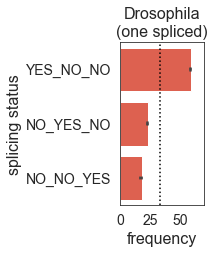

In [12]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO','NO_YES_NO','NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Drosophila\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7C_S2_splicing_order_3int_oneSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [14]:
introns_1yes = S2_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("S2 3 introns, 1 spliced, in order p-value: "+str(p))

S2 3 introns, 1 spliced, in order p-value: 6.261316476841944e-44


In [15]:
introns_1yes = S2_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO','NO_YES_NO','NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("S2, 1 intron "+i+" p-value: "+str(p))

S2, 1 intron YES_NO_NO p-value: 6.261316476841944e-44
S2, 1 intron NO_YES_NO p-value: 2.248625393734018e-09
S2, 1 intron NO_NO_YES p-value: 1.5118374375718658e-19


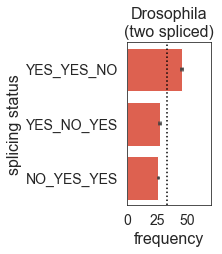

In [13]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO','YES_NO_YES','NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Drosophila\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7C_S2_splicing_order_3int_twoSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [16]:
introns_2yes = S2_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("S2 3 introns, 2 spliced, in order p-value: "+str(p))


S2 3 introns, 2 spliced, in order p-value: 6.286427885074806e-16


In [17]:
introns_2yes = S2_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO','YES_NO_YES','NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("S2, 2 spliced, "+i+" p-value: "+str(p))
    

S2, 2 spliced, YES_YES_NO p-value: 6.286427885074806e-16
S2, 2 spliced, YES_NO_YES p-value: 0.00023053637734700864
S2, 2 spliced, NO_YES_YES p-value: 2.1990870580684497e-06


In [33]:
# estimating the statistical probability that introns are spliced in order

in_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']=='YES_NO_NO')]['counts'])+sum(S2_introns_2yes[(S2_introns_2yes['pattern']=='YES_YES_NO')]['counts']) 
no_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']!='YES_NO_NO')]['counts'])+sum(S2_introns_2yes[(S2_introns_2yes['pattern']!='YES_YES_NO')]['counts']) 

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("S2 3 introns spliced in order p-value: "+str(p))


S2 3 introns spliced in order p-value: 4.5146063096662945e-72


In [18]:
K562_5_multi_introns_df = pd.concat([K562_5a_multi_introns_df, K562_5b_multi_introns_df])
K562_1_3introns_splicing_patterns = get_splicing_pattern_counts(K562_1_multi_introns_df, 3)
K562_2_3introns_splicing_patterns = get_splicing_pattern_counts(K562_2_multi_introns_df, 3)
K562_3_3introns_splicing_patterns = get_splicing_pattern_counts(K562_3_multi_introns_df, 3)
K562_4_3introns_splicing_patterns = get_splicing_pattern_counts(K562_4_multi_introns_df, 3)
K562_5_3introns_splicing_patterns = get_splicing_pattern_counts(K562_5_multi_introns_df, 3)

K562_1_3introns_splicing_patterns['rep'] = 'K562_1'
K562_2_3introns_splicing_patterns['rep'] = 'K562_2'
K562_3_3introns_splicing_patterns['rep'] = 'K562_3'
K562_4_3introns_splicing_patterns['rep'] = 'K562_4'
K562_5_3introns_splicing_patterns['rep'] = 'K562_5'

K562_3introns_splicing_patterns = pd.concat([K562_1_3introns_splicing_patterns, K562_2_3introns_splicing_patterns, K562_3_3introns_splicing_patterns, K562_4_3introns_splicing_patterns, K562_5_3introns_splicing_patterns])

K562_1_introns_1yes, K562_1_introns_2yes = get_intron_splicing_percent(K562_1_3introns_splicing_patterns, 3)
K562_2_introns_1yes, K562_2_introns_2yes = get_intron_splicing_percent(K562_2_3introns_splicing_patterns, 3)
K562_3_introns_1yes, K562_3_introns_2yes = get_intron_splicing_percent(K562_3_3introns_splicing_patterns, 3)
K562_4_introns_1yes, K562_4_introns_2yes = get_intron_splicing_percent(K562_4_3introns_splicing_patterns, 3)
K562_5_introns_1yes, K562_5_introns_2yes = get_intron_splicing_percent(K562_5_3introns_splicing_patterns, 3)

K562_introns_1yes = pd.concat([K562_1_introns_1yes, K562_2_introns_1yes, K562_3_introns_1yes, K562_4_introns_1yes, K562_5_introns_1yes])
K562_introns_2yes = pd.concat([K562_1_introns_2yes, K562_2_introns_2yes, K562_3_introns_2yes, K562_4_introns_2yes, K562_5_introns_2yes])


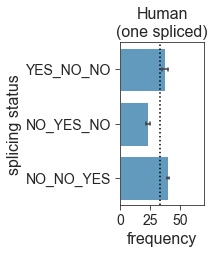

In [12]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO','NO_YES_NO','NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Human\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7C_K562_splicing_order_3int_oneSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [20]:
introns_1yes = K562_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("K562 3 introns, 1 spliced, in order p-value: "+str(p))


K562 3 introns, 1 spliced, in order p-value: 4.732446680010153e-07


In [21]:
introns_1yes = K562_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO','NO_YES_NO','NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("K562, 1 intron "+i+" p-value: "+str(p))
    

K562, 1 intron YES_NO_NO p-value: 4.732446680010153e-07
K562, 1 intron NO_YES_NO p-value: 1.357151626541625e-23
K562, 1 intron NO_NO_YES p-value: 5.658553035449832e-06


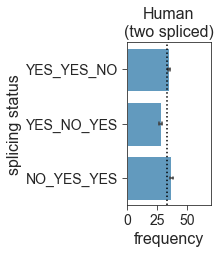

In [13]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO','YES_NO_YES','NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Human\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7C_K562_splicing_order_3int_twoSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [22]:
introns_2yes = K562_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("K562 3 introns, 2 spliced, in order p-value: "+str(p))


K562 3 introns, 2 spliced, in order p-value: 0.0470621187679655


In [23]:
introns_2yes = K562_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO','YES_NO_YES','NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("K562, 2 spliced, "+i+" p-value: "+str(p))
    

K562, 2 spliced, YES_YES_NO p-value: 0.0470621187679655
K562, 2 spliced, YES_NO_YES p-value: 8.993703294595027e-09
K562, 2 spliced, NO_YES_YES p-value: 0.00032743190069052953


In [ ]:
### Supplemental Figure S7D

In [24]:
S2_1_multi_introns_df = pd.concat([S2_1a_multi_introns_df, S2_1b_multi_introns_df])
S2_1_4introns_splicing_patterns = get_splicing_pattern_counts(S2_1_multi_introns_df, 4)
S2_2_4introns_splicing_patterns = get_splicing_pattern_counts(S2_2_multi_introns_df, 4)
S2_3_4introns_splicing_patterns = get_splicing_pattern_counts(S2_3_multi_introns_df, 4)

S2_1_4introns_splicing_patterns['rep'] = 'S2_1'
S2_2_4introns_splicing_patterns['rep'] = 'S2_2'
S2_3_4introns_splicing_patterns['rep'] = 'S2_3'

S2_4introns_splicing_patterns = pd.concat([S2_1_4introns_splicing_patterns, S2_2_4introns_splicing_patterns, S2_3_4introns_splicing_patterns])

S2_1_introns_1yes, S2_1_introns_2yes, S2_1_introns_3yes = get_intron_splicing_percent(S2_1_4introns_splicing_patterns, 4)
S2_2_introns_1yes, S2_2_introns_2yes, S2_2_introns_3yes = get_intron_splicing_percent(S2_2_4introns_splicing_patterns, 4)
S2_3_introns_1yes, S2_3_introns_2yes, S2_3_introns_3yes = get_intron_splicing_percent(S2_3_4introns_splicing_patterns, 4)

S2_introns_1yes = pd.concat([S2_1_introns_1yes, S2_2_introns_1yes, S2_3_introns_1yes])
S2_introns_2yes = pd.concat([S2_1_introns_2yes, S2_2_introns_2yes, S2_3_introns_2yes])
S2_introns_3yes = pd.concat([S2_1_introns_3yes, S2_2_introns_3yes, S2_3_introns_3yes])

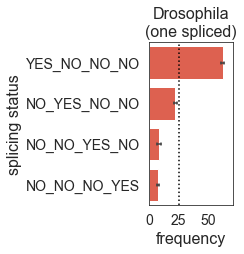

In [21]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Drosophila\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7D_S2_splicing_order_4int_oneSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [26]:
introns_1yes = S2_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("S2 4 introns, 1 spliced, in order p-value: "+str(p))


S2 4 introns, 1 spliced, in order p-value: 1.5138032660642142e-25


In [27]:
introns_1yes = S2_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("S2 4 introns, 1 spliced "+i+" p-value: "+str(p))
    

S2 4 introns, 1 spliced YES_NO_NO_NO p-value: 1.5138032660642142e-25
S2 4 introns, 1 spliced NO_YES_NO_NO p-value: 0.4384596004081659
S2 4 introns, 1 spliced NO_NO_YES_NO p-value: 1.194922974267758e-09
S2 4 introns, 1 spliced NO_NO_NO_YES p-value: 1.8829323419482833e-08


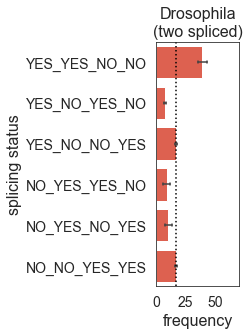

In [22]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=16.67, color='black', linestyle=":")

plt.title("Drosophila\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7D_S2_splicing_order_4int_twoSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [28]:
introns_2yes = S2_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.166666666667)
print("S2 4 introns, 2 spliced, in order p-value: "+str(p))


S2 4 introns, 2 spliced, in order p-value: 8.39919666130689e-14


In [29]:
introns_2yes = S2_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.166666666667))

    print("S2 4 introns, 2 spliced "+i+" p-value: "+str(p))
    

S2 4 introns, 2 spliced YES_YES_NO_NO p-value: 8.39919666130689e-14
S2 4 introns, 2 spliced YES_NO_YES_NO p-value: 0.00016857318894086825
S2 4 introns, 2 spliced YES_NO_NO_YES p-value: 0.9999999999999929
S2 4 introns, 2 spliced NO_YES_YES_NO p-value: 0.012489455115622146
S2 4 introns, 2 spliced NO_YES_NO_YES p-value: 0.020501054128051553
S2 4 introns, 2 spliced NO_NO_YES_YES p-value: 0.9999999999999929


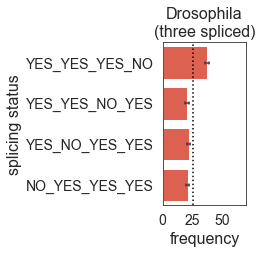

In [23]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_3yes, palette=fill_colors,
           order=['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Drosophila\n(three spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7D_S2_splicing_order_4int_threeSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [30]:
introns_3yes = S2_introns_3yes.copy()

in_order = sum(introns_3yes[(introns_3yes['pattern']=='YES_YES_YES_NO')]['counts'])
no_order = sum(introns_3yes[(introns_3yes['pattern']!='YES_YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("S2 4 introns, 3 spliced, in order p-value: "+str(p))


S2 4 introns, 3 spliced, in order p-value: 2.3778388820777556e-06


In [31]:
introns_3yes = S2_introns_3yes.copy()
splicing_patterns = ['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_3yes[(introns_3yes['pattern']==i)]['counts']),sum(introns_3yes[(introns_3yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("S2 4 introns, 3 spliced "+i+" p-value: "+str(p))
    

S2 4 introns, 3 spliced YES_YES_YES_NO p-value: 2.3778388820777556e-06
S2 4 introns, 3 spliced YES_YES_NO_YES p-value: 0.05866182352495811
S2 4 introns, 3 spliced YES_NO_YES_YES p-value: 0.2472142937958291
S2 4 introns, 3 spliced NO_YES_YES_YES p-value: 0.0770118199183959


In [32]:

exp_in_order = 1/4*np.sum(S2_introns_1yes['counts'])+1/6*np.sum(S2_introns_2yes['counts'])+1/4*np.sum(S2_introns_3yes['counts'])
total = np.sum(S2_introns_1yes['counts'])+np.sum(S2_introns_2yes['counts'])+np.sum(S2_introns_3yes['counts'])

S2_exp_in_order_percent = exp_in_order / total


in_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']=='YES_NO_NO_NO')]['counts']) + sum(S2_introns_2yes[(S2_introns_2yes['pattern']=='YES_YES_NO_NO')]['counts']) + sum(S2_introns_3yes[(S2_introns_3yes['pattern']=='YES_YES_YES_NO')]['counts'])
no_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']!='YES_NO_NO_NO')]['counts']) + sum(S2_introns_2yes[(S2_introns_2yes['pattern']!='YES_YES_NO_NO')]['counts']) + sum(S2_introns_3yes[(S2_introns_3yes['pattern']!='YES_YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=S2_exp_in_order_percent)
print("S2 4 introns, in order p-value: "+str(p))



S2 4 introns, in order p-value: 8.998239500304352e-35


In [34]:
K562_1_4introns_splicing_patterns = get_splicing_pattern_counts(K562_1_multi_introns_df, 4)
K562_2_4introns_splicing_patterns = get_splicing_pattern_counts(K562_2_multi_introns_df, 4)
K562_3_4introns_splicing_patterns = get_splicing_pattern_counts(K562_3_multi_introns_df, 4)
K562_4_4introns_splicing_patterns = get_splicing_pattern_counts(K562_4_multi_introns_df, 4)
K562_5_4introns_splicing_patterns = get_splicing_pattern_counts(K562_5_multi_introns_df, 4)

K562_1_4introns_splicing_patterns['rep'] = 'K562_1'
K562_2_4introns_splicing_patterns['rep'] = 'K562_2'
K562_3_4introns_splicing_patterns['rep'] = 'K562_3'
K562_4_4introns_splicing_patterns['rep'] = 'K562_4'
K562_5_4introns_splicing_patterns['rep'] = 'K562_5'

K562_4introns_splicing_patterns = pd.concat([K562_1_4introns_splicing_patterns, K562_2_4introns_splicing_patterns, K562_3_4introns_splicing_patterns, K562_4_4introns_splicing_patterns, K562_5_4introns_splicing_patterns])

K562_1_introns_1yes, K562_1_introns_2yes, K562_1_introns_3yes = get_intron_splicing_percent(K562_1_4introns_splicing_patterns, 4)
K562_2_introns_1yes, K562_2_introns_2yes, K562_2_introns_3yes = get_intron_splicing_percent(K562_2_4introns_splicing_patterns, 4)
K562_3_introns_1yes, K562_3_introns_2yes, K562_3_introns_3yes = get_intron_splicing_percent(K562_3_4introns_splicing_patterns, 4)
K562_4_introns_1yes, K562_4_introns_2yes, K562_4_introns_3yes = get_intron_splicing_percent(K562_4_4introns_splicing_patterns, 4)
K562_5_introns_1yes, K562_5_introns_2yes, K562_5_introns_3yes = get_intron_splicing_percent(K562_5_4introns_splicing_patterns, 4)

K562_introns_1yes = pd.concat([K562_1_introns_1yes, K562_2_introns_1yes, K562_3_introns_1yes, K562_4_introns_1yes, K562_5_introns_1yes])
K562_introns_2yes = pd.concat([K562_1_introns_2yes, K562_2_introns_2yes, K562_3_introns_2yes, K562_4_introns_2yes, K562_5_introns_2yes])
K562_introns_3yes = pd.concat([K562_1_introns_3yes, K562_2_introns_3yes, K562_3_introns_3yes, K562_4_introns_3yes, K562_5_introns_3yes])


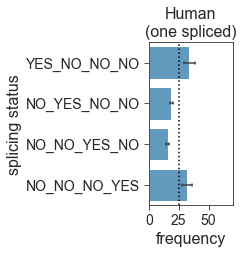

In [17]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Human\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7D_K562_splicing_order_4int_oneSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [36]:
introns_1yes = K562_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("K562 4 introns, 1 spliced, in order p-value: "+str(p))


K562 4 introns, 1 spliced, in order p-value: 4.185606692645788e-10


In [37]:
introns_1yes = K562_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("K562 4 introns, 1 spliced "+i+" p-value: "+str(p))
    

K562 4 introns, 1 spliced YES_NO_NO_NO p-value: 4.185606692645788e-10
K562 4 introns, 1 spliced NO_YES_NO_NO p-value: 0.0025827779129298295
K562 4 introns, 1 spliced NO_NO_YES_NO p-value: 2.6436219632306826e-07
K562 4 introns, 1 spliced NO_NO_NO_YES p-value: 0.1582269557005106


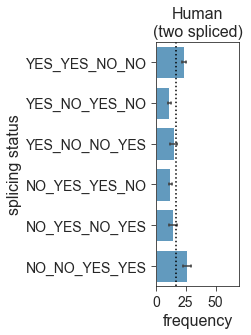

In [18]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=16.67, color='black', linestyle=":")

plt.title("Human\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7D_K562_splicing_order_4int_twoSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [38]:
introns_2yes = K562_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.166666666667)
print("K562 4 introns, 2 spliced, in order p-value: "+str(p))


K562 4 introns, 2 spliced, in order p-value: 2.520200305819742e-07


In [39]:
introns_2yes = K562_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.166666666667))

    print("K562 4 introns, 2 spliced "+i+" p-value: "+str(p))
    

K562 4 introns, 2 spliced YES_YES_NO_NO p-value: 2.520200305819742e-07
K562 4 introns, 2 spliced YES_NO_YES_NO p-value: 0.0020564696517107054
K562 4 introns, 2 spliced YES_NO_NO_YES p-value: 0.9093523466923521
K562 4 introns, 2 spliced NO_YES_YES_NO p-value: 0.010209861442527158
K562 4 introns, 2 spliced NO_YES_NO_YES p-value: 0.0006040346219710136
K562 4 introns, 2 spliced NO_NO_YES_YES p-value: 0.0004917570752833293


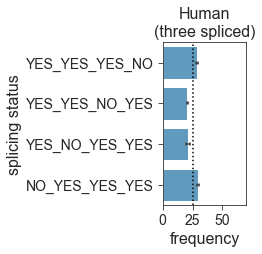

In [19]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_3yes, palette=fill_colors,
           order=['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Human\n(three spliced)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_7D_K562_splicing_order_4int_threeSpliced_noFirst_noLast.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [40]:
introns_3yes = K562_introns_3yes.copy()

in_order = sum(introns_3yes[(introns_3yes['pattern']=='YES_YES_YES_NO')]['counts'])
no_order = sum(introns_3yes[(introns_3yes['pattern']!='YES_YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("K562 4 introns, 3 spliced, in order p-value: "+str(p))


K562 4 introns, 3 spliced, in order p-value: 0.02164008040032389


In [41]:
introns_3yes = K562_introns_3yes.copy()
splicing_patterns = ['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_3yes[(introns_3yes['pattern']==i)]['counts']),sum(introns_3yes[(introns_3yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("K562 4 introns, 3 spliced "+i+" p-value: "+str(p))
    

K562 4 introns, 3 spliced YES_YES_YES_NO p-value: 0.02164008040032389
K562 4 introns, 3 spliced YES_YES_NO_YES p-value: 0.012548483464619203
K562 4 introns, 3 spliced YES_NO_YES_YES p-value: 0.040528715608123066
K562 4 introns, 3 spliced NO_YES_YES_YES p-value: 0.028025326158081246


In [ ]:
### Supplemental Figure 7E

In [8]:
def get_all_multi_introns(read_junctions, intron_min):

    multi_introns = []

    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if ((len(read_junctions[read][gene]) >= intron_min) & (len(read_junctions[read][gene]) <= 10)):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    temp = [] 

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                    dif = (np.max(read_introns_df['intron_count'])-np.min(read_introns_df['intron_count'])+1)
                    if (len(read_introns_df)==dif):

                        for i in range(len(read_introns_df)):
                            intron_count = read_introns_df.iloc[i]['intron_count']
                            intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                            intron_start = str(read_introns_df.iloc[i]['start'])
                            intron_end = str(read_introns_df.iloc[i]['end'])
                            intron_strand = read_introns_df.iloc[i]['strand']
                            intron_splice = read_introns_df.iloc[i]['splice_status']
                            intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                            temp.append(intron_splice)


                        if (intron_strand=='+'):

                            final = []
                            final.append(read)
                            final.append(intron_strand)

                            for i in temp:
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_')

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)


                        if (intron_strand=='-'):

                            final = []
                            final.append(read)
                            final.append(intron_strand)

                            for i in reversed(temp):
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_') 

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)

    multi_introns_df = pd.DataFrame(multi_introns)
    multi_introns_df.columns = ['read','strand','int1','int2','int3','int4','int5','int6','int7','int8','int9','int10']
    multi_introns_df = multi_introns_df.sort_values(by=['read']).reset_index(drop=True)

    return multi_introns_df


def get_splicing_patterns(multi_introns_df, total):
    
    splice_status_list = []
    multi_introns_df = multi_introns_df.drop(['read','strand'], 1)

    for i in range(0, len(multi_introns_df)):

        itrons_per_read = sum(multi_introns_df.iloc[i]!='_')

        for j in range(0, itrons_per_read-(total-1)):

            splice_status = multi_introns_df.iloc[i][j:j+total].tolist()

            if (splice_status.count('YES')>0) & (splice_status.count('NO')>0):
                splice_status_list.append(splice_status)

    splicing_patterns_df = pd.DataFrame(splice_status_list)
    
    if (total==3):
        splicing_patterns_df.columns = ['intron 1','intron 2','intron 3']

    if (total==4):
        splicing_patterns_df.columns = ['intron 1','intron 2','intron 3','intron 4']

    if (total==5):
        splicing_patterns_df.columns = ['intron 1','intron 2','intron 3','intron 4','intron 5']

    return splicing_patterns_df


def get_intron_quad_order(intron_quads_df):    
    
    intron_quads_order = []

    for i in range(len(intron_quads_df)):
        read =  intron_quads_df.iloc[i]['read']
        strand = intron_quads_df.iloc[i]['strand']
        int1_splice = intron_quads_df.iloc[i]['int1_splice']
        int2_splice = intron_quads_df.iloc[i]['int2_splice']
        int3_splice = intron_quads_df.iloc[i]['int3_splice']
        int4_splice = intron_quads_df.iloc[i]['int4_splice']

        if ((int1_splice == int2_splice) & (int1_splice == int3_splice) & (int1_splice == int4_splice)):
            continue

        else:         
            if (strand == "+"):
                intron_quads_order.append([read, int1_splice, int2_splice, int3_splice, int4_splice])

            elif (strand == "-"):
                intron_quads_order.append([read, int4_splice, int3_splice, int2_splice, int1_splice])

    intron_quads_order_df = pd.DataFrame(intron_quads_order)
    intron_quads_order_df.columns = ['read','intron 1','intron 2','intron 3', 'intron 4']

    intron_quads_plotting_df = intron_quads_order_df.groupby(['intron 1','intron 2','intron 3','intron 4']).size().to_frame('count').reset_index()

    return intron_quads_plotting_df


def get_df_for_plotting_intron_quads(intron_quads_plotting_df):
        
    plot_dict = {'intron 1': [0.0, 0.0, 0.0, 0.0], 'intron 2': [0.0, 0.0, 0.0, 0.0], 'intron 3': [0.0, 0.0, 0.0, 0.0], 'intron 4': [0.0, 0.0, 0.0, 0.0]}
    plot_df = pd.DataFrame(data=plot_dict)
    plot_df.index = ['intron 1','intron 2','intron 3','intron 4']
    
    df = intron_quads_plotting_df
    total = float(np.sum(df['count']))


    for i in range(0,len(plot_df.index)):

        for j in range(0,i):

            row = plot_df.index[i]
            column = plot_df.columns[j]

            plot_df[row][column] = float(np.sum(df[(df[row]=='NO') & (df[column]=='NO')]['count']))/float(total)
        

    for i in range(0,len(plot_df.columns)):

        for j in range(0,i):

            column = plot_df.columns[i]
            row = plot_df.index[j]

            plot_df[row][column] = float(np.sum(df[(df[row]=='YES') & (df[column]=='YES')]['count']))/float(total)
    
   
    return plot_df


def get_df_for_plotting_intron_quads_combined(intron_quads_plotting_df):
        
    plot_dict = {'intron 1': [0.0, 0.0, 0.0, 0.0], 'intron 2': [0.0, 0.0, 0.0, 0.0], 'intron 3': [0.0, 0.0, 0.0, 0.0], 'intron 4': [0.0, 0.0, 0.0, 0.0]}
    plot_df = pd.DataFrame(data=plot_dict)
    plot_df.index = ['intron 1','intron 2','intron 3','intron 4']
    
    df = intron_quads_plotting_df
    total = float(np.sum(df['count']))


    for i in range(0,len(plot_df.columns)):

        for j in range(0,i):

            column = plot_df.columns[i]
            row = plot_df.index[j]

            plot_df[row][column] = float(np.sum(df[df[row]==df[column]]['count']))/float(total)
    
    
    return plot_df
    

In [4]:
# Statistics for K562 heatmap

# open dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = np.load('/path/to/K562_1_splicing_dictionary.npy').item() 
K562_2_splice_dictionary = np.load('/path/to/K562_2_splicing_dictionary.npy').item() 
K562_3_splice_dictionary = np.load('/path/to/K562_3_splicing_dictionary.npy').item() 
K562_4_splice_dictionary = np.load('/path/to/K562_4_splicing_dictionary.npy').item() 
K562_5a_splice_dictionary = np.load('/path/to/K562_5a_splicing_dictionary.npy').item() 
K562_5b_splice_dictionary = np.load('/path/to/K562_5b_splicing_dictionary.npy').item() 

In [5]:
# get multi intron df for K562
K562_1_all_multi_introns_df = get_all_multi_introns(K562_1_splice_dictionary, 3)
K562_2_all_multi_introns_df = get_all_multi_introns(K562_2_splice_dictionary, 3)
K562_3_all_multi_introns_df = get_all_multi_introns(K562_3_splice_dictionary, 3)
K562_4_all_multi_introns_df = get_all_multi_introns(K562_4_splice_dictionary, 3)
K562_5a_all_multi_introns_df = get_all_multi_introns(K562_5a_splice_dictionary, 3)
K562_5b_all_multi_introns_df = get_all_multi_introns(K562_5b_splice_dictionary, 3)
K562_all_multi_introns_df = pd.concat([K562_1_all_multi_introns_df,K562_2_all_multi_introns_df,K562_3_all_multi_introns_df,K562_4_all_multi_introns_df,K562_5a_all_multi_introns_df,K562_5b_all_multi_introns_df],axis=0).reset_index(drop=True)

In [6]:
K562_4introns_splicing = get_splicing_patterns(K562_all_multi_introns_df, 4)

In [7]:
K562_4intron_quad_order = K562_4introns_splicing.groupby(['intron 1','intron 2','intron 3','intron 4']).size().to_frame('count').reset_index()

In [7]:
def count_intron_pairs(intronA,intronB):
    
    count_same = K562_4intron_quad_order[(K562_4intron_quad_order[intronA] == K562_4intron_quad_order[intronB])]['count'].sum()
    count_diff = K562_4intron_quad_order[(K562_4intron_quad_order[intronA] != K562_4intron_quad_order[intronB])]['count'].sum()
    
    prob_list = np.array([count_same,count_diff])
    
    return prob_list   

In [18]:
combinations = [['intron 1','intron 2'],['intron 1','intron 3'],['intron 1','intron 4'],
               ['intron 2','intron 3'],['intron 2','intron 4'],['intron 3','intron 4']]

# Use chi-square test with 2x2 contingency table

counts_dict_chi = {}
count_freq_dict = {}

for pair in combinations:
    freq = count_intron_pairs(pair[0],pair[1])
    pair_name = "_".join(pair)
    counts_dict_chi[pair_name] = freq
    
    count_same = freq[0]
    count_freq_dict[pair_name] = count_same
    
    
stats_list = []
for k1, k2 in itertools.combinations(counts_dict_chi, 2):
    p = scipy.stats.chi2_contingency([counts_dict_chi[k1],counts_dict_chi[k2]])[1]
    count_same_1 = count_freq_dict[k1]
    count_same_2 = count_freq_dict[k2]
    stats_list.append([k1,k2,count_same_1,count_same_2,p])
    
    
stats_df_chi = pd.DataFrame(stats_list)
stats_df_chi.columns = ['intron_pair_1','intron_pair_2','count_same_pair_1','count_same_pair_2','chi_square_exact_pvalue']

padj_threshold = 0.05 / len(stats_df_chi)
print(padj_threshold)

stats_df_chi['significant_post_correction'] = 'no'
stats_df_chi.loc[stats_df_chi['chi_square_exact_pvalue'] < padj_threshold,'significant_post_correction'] = 'yes'
stats_df_chi

0.0033333333333333335


,intron_pair_1,intron_pair_2,count_same_pair_1,count_same_pair_2,chi_square_exact_pvalue,significant_post_correction
0,intron 1_intron 2,intron 1_intron 3,1077,915,1.458742e-06,yes
1,intron 1_intron 2,intron 1_intron 4,1077,811,1.437520e-15,yes
2,intron 1_intron 2,intron 2_intron 3,1077,1136,8.491441e-02,no
3,intron 1_intron 2,intron 2_intron 4,1077,950,1.679125e-04,yes
4,intron 1_intron 2,intron 3_intron 4,1077,1186,1.340605e-03,yes
5,intron 1_intron 3,intron 1_intron 4,915,811,1.633125e-03,yes
6,intron 1_intron 3,intron 2_intron 3,915,1136,5.267828e-11,yes
7,intron 1_intron 3,intron 2_intron 4,915,950,3.049008e-01,no
8,intron 1_intron 3,intron 3_intron 4,915,1186,9.008679e-16,yes
9,intron 1_intron 4,intron 2_intron 3,811,1136,2.496254e-22,yes


In [17]:
stats_df_chi.to_csv('/path/to/stats_coordination_heatmap.txt', sep='\t', header=True, index=False)

In [ ]:
### Supplementary Figure 7F (lymphoblast coordination)

In [6]:
BL1184_1_splice_dictionary = np.load('/path/to/BL1184_1_splicing_dictionary.npy',  encoding='latin1').item()
BL1184_2_splice_dictionary = np.load('/path/to/BL1184_2_splicing_dictionary.npy',  encoding='latin1').item()

# get multi intron df for K562
BL1184_2_all_multi_introns_df = get_all_multi_introns(BL1184_2_splice_dictionary, 3)
BL1184_1_all_multi_introns_df = get_all_multi_introns(BL1184_1_splice_dictionary, 3)

BL1184_all_multi_introns_df = pd.concat([BL1184_2_all_multi_introns_df,BL1184_1_all_multi_introns_df]).reset_index(drop=True)

In [11]:
BL1184_4introns_splicing = get_splicing_patterns(BL1184_all_multi_introns_df, 4)
BL1184_4intron_quad_order = BL1184_4introns_splicing.groupby(['intron 1','intron 2','intron 3','intron 4']).size().to_frame('count').reset_index()

In [12]:
BL1184_4intron_plot_df = get_df_for_plotting_intron_quads(BL1184_4intron_quad_order)

In [13]:
BL1184_4intron_combined_plot_df = get_df_for_plotting_intron_quads_combined(BL1184_4intron_quad_order)

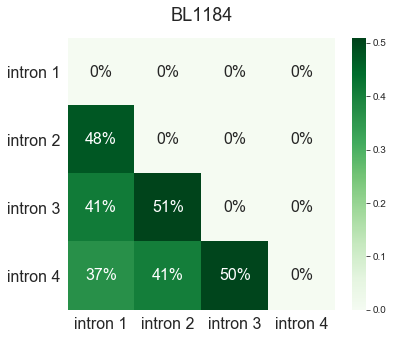

In [23]:
fig, ax = plt.subplots(figsize=(6,5))

sns.heatmap(BL1184_4intron_combined_plot_df, annot=True, center=0.25, annot_kws={"size": 16}, fmt='.0%', cmap="Greens")

plt.tick_params(axis='both', labelsize=16)
plt.title("BL1184", fontsize=18, y=1.04)
plt.yticks(rotation=0)

plt.savefig('/path/to/Supplemental_Figure_7F_BL1184_heatmap_coordination.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [19]:
def count_intron_pairs_2(intronA,intronB):
    
    count_same = BL1184_4intron_quad_order[(BL1184_4intron_quad_order[intronA] == BL1184_4intron_quad_order[intronB])]['count'].sum()
    count_diff = BL1184_4intron_quad_order[(BL1184_4intron_quad_order[intronA] != BL1184_4intron_quad_order[intronB])]['count'].sum()
    
    prob_list = np.array([count_same,count_diff])
    
    return prob_list   

In [21]:
combinations = [['intron 1','intron 2'],['intron 1','intron 3'],['intron 1','intron 4'],
               ['intron 2','intron 3'],['intron 2','intron 4'],['intron 3','intron 4']]

# Use chi-square test with 2x2 contingency table

BL_counts_dict_chi = {}
BL_count_freq_dict = {}

for pair in combinations:
    freq = count_intron_pairs_2(pair[0],pair[1])
    pair_name = "_".join(pair)
    BL_counts_dict_chi[pair_name] = freq
    
    count_same = freq[0]
    BL_count_freq_dict[pair_name] = count_same
    
    
stats_list = []
for k1, k2 in itertools.combinations(BL_counts_dict_chi, 2):
    p = scipy.stats.chi2_contingency([BL_counts_dict_chi[k1],BL_counts_dict_chi[k2]])[1]
    count_same_1 = BL_count_freq_dict[k1]
    count_same_2 = BL_count_freq_dict[k2]
    stats_list.append([k1,k2,count_same_1,count_same_2,p])
    
    
BL_stats_df_chi = pd.DataFrame(stats_list)
BL_stats_df_chi.columns = ['intron_pair_1','intron_pair_2','count_same_pair_1','count_same_pair_2','chi_square_exact_pvalue']

padj_threshold = 0.05 / len(BL_stats_df_chi)
print(padj_threshold)

BL_stats_df_chi['significant_post_correction'] = 'no'
BL_stats_df_chi.loc[BL_stats_df_chi['chi_square_exact_pvalue'] < padj_threshold,'significant_post_correction'] = 'yes'
BL_stats_df_chi

0.0033333333333333335


,intron_pair_1,intron_pair_2,count_same_pair_1,count_same_pair_2,chi_square_exact_pvalue,significant_post_correction
0,intron 1_intron 2,intron 1_intron 3,516,446,2.846428e-03,yes
1,intron 1_intron 2,intron 1_intron 4,516,399,4.511344e-07,yes
2,intron 1_intron 2,intron 2_intron 3,516,551,1.439445e-01,no
3,intron 1_intron 2,intron 2_intron 4,516,440,1.172838e-03,yes
4,intron 1_intron 2,intron 3_intron 4,516,546,2.125934e-01,no
5,intron 1_intron 3,intron 1_intron 4,446,399,4.273235e-02,no
6,intron 1_intron 3,intron 2_intron 3,446,551,7.346217e-06,yes
7,intron 1_intron 3,intron 2_intron 4,446,440,8.270294e-01,no
8,intron 1_intron 3,intron 3_intron 4,446,546,1.959331e-05,yes
9,intron 1_intron 4,intron 2_intron 3,399,551,6.214229e-11,yes


In [2]:
# SUPPLEMENTAL FIGURE 7G - distance transcribed before splicing plots compared with splicing yield

# upload splicing yield file
splicing_yield_df = pd.read_csv('/path/to/annotation_files/K562_splicing_yield.bed',header=None, sep='\t')
splicing_yield_df.columns = ['chrom','intron_start','intron_end','eta','strand']
splicing_yield_df['intron_start']  = splicing_yield_df['intron_start'].astype(int)
splicing_yield_df['chrom'] = splicing_yield_df['chrom'].str[3:]

K562_1_splice_df = pd.read_table("/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_2_splice_df = pd.read_table("/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_3_splice_df = pd.read_table("/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_4_splice_df = pd.read_table("/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5a_splice_df = pd.read_table("/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5b_splice_df = pd.read_table("/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5_splice_df = pd.concat([K562_5a_splice_df,K562_5b_splice_df],axis=0)

# get splicing yield 
K562_1_splice_df_eta = pd.merge(K562_1_splice_df,splicing_yield_df,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_2_splice_df_eta = pd.merge(K562_2_splice_df,splicing_yield_df,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_3_splice_df_eta = pd.merge(K562_3_splice_df,splicing_yield_df,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_4_splice_df_eta = pd.merge(K562_4_splice_df,splicing_yield_df,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_5_splice_df_eta = pd.merge(K562_5_splice_df,splicing_yield_df,on=['chrom','intron_start','intron_end','strand'], how='left')


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


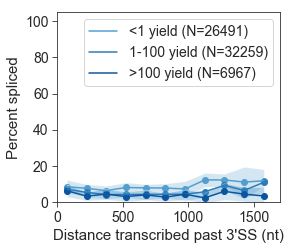

In [3]:
low = 1
high = 100


K562_1_low_splice_df = K562_1_splice_df_eta[K562_1_splice_df_eta['eta'] < low]
K562_1_med_splice_df = K562_1_splice_df_eta[(K562_1_splice_df_eta['eta'] > low) & (K562_1_splice_df_eta['eta'] < high)]
K562_1_high_splice_df = K562_1_splice_df_eta[K562_1_splice_df_eta['eta'] > high]

K562_2_low_splice_df = K562_2_splice_df_eta[K562_2_splice_df_eta['eta'] < low]
K562_2_med_splice_df = K562_2_splice_df_eta[(K562_2_splice_df_eta['eta'] > low) & (K562_2_splice_df_eta['eta'] < high)]
K562_2_high_splice_df = K562_2_splice_df_eta[K562_2_splice_df_eta['eta'] > high]

K562_3_low_splice_df = K562_3_splice_df_eta[K562_3_splice_df_eta['eta'] < low]
K562_3_med_splice_df = K562_3_splice_df_eta[(K562_3_splice_df_eta['eta'] > low) & (K562_3_splice_df_eta['eta'] < high)]
K562_3_high_splice_df = K562_3_splice_df_eta[K562_3_splice_df_eta['eta'] > high]

K562_4_low_splice_df = K562_4_splice_df_eta[K562_4_splice_df_eta['eta'] < low]
K562_4_med_splice_df = K562_4_splice_df_eta[(K562_4_splice_df_eta['eta'] > low) & (K562_4_splice_df_eta['eta'] < high)]
K562_4_high_splice_df = K562_4_splice_df_eta[K562_4_splice_df_eta['eta'] > high]

K562_5_low_splice_df = K562_5_splice_df_eta[K562_5_splice_df_eta['eta'] < low]
K562_5_med_splice_df = K562_5_splice_df_eta[(K562_5_splice_df_eta['eta'] > low) & (K562_5_splice_df_eta['eta'] < high)]
K562_5_high_splice_df = K562_5_splice_df_eta[K562_5_splice_df_eta['eta'] > high]


######### set variables for plot #########
window = 150
plot_min = 0
plot_max = 1650      

samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

######### get info for each sample #########

### short introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_low_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
short_N = np.sum(plot_df['count'])
short_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

short_plot_df = pd.DataFrame(mean)
short_plot_df.columns = ['range','mean']
short_plot_df['stdev'] = stdev


### medium introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_med_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
med_N = np.sum(plot_df['count'])
med_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

med_plot_df = pd.DataFrame(mean)
med_plot_df.columns = ['range','mean']
med_plot_df['stdev'] = stdev


### long introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_high_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
long_N = np.sum(plot_df['count'])
long_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

long_plot_df = pd.DataFrame(mean)
long_plot_df.columns = ['range','mean']
long_plot_df['stdev'] = stdev


######### plot mean and standard deviation for all samples #########

x = short_plot_df['range'].values
short_y = short_plot_df['mean'].values
short_err = short_plot_df['stdev'].values
med_y = med_plot_df['mean'].values
med_err = med_plot_df['stdev'].values
long_y = long_plot_df['mean'].values
long_err = long_plot_df['stdev'].values

fig, ax = plt.subplots(figsize=(4,3.5))

ax = plt.plot(x, short_y, color=sns.color_palette("Blues")[3], label="<"+str(low)+" yield (N="+str(short_N)+")")
plt.fill_between(x, short_y-short_err, short_y+short_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, short_y, color=sns.color_palette("Blues")[3])

plt.plot(x, med_y, color=sns.color_palette("Blues")[4], label=str(low)+"-"+str(high)+" yield (N="+str(med_N)+")")
plt.fill_between(x, med_y-med_err, long_y+long_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, med_y, color=sns.color_palette("Blues")[4])

plt.plot(x, long_y, color=sns.color_palette("Blues")[5], label=">"+str(high)+" yield (N="+str(long_N)+")")
plt.fill_between(x, long_y-long_err, long_y+long_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, long_y, color=sns.color_palette("Blues")[5])

plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
#plt.text(100, 98, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(fontsize=14)

plt.xlim(0,1700)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_7G_K562_distance_spliced_bySplicingYield_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
short_df.to_csv('/path/to/human_distance_transcribed_lowYield_plot_df.txt', sep='\t', header=True, index=False)
med_df.to_csv('/path/to/human_distance_transcribed_medYield_plot_df.txt', sep='\t', header=True, index=False)
long_df.to_csv('/path/to/human_distance_transcribed_highYield_plot_df.txt', sep='\t', header=True, index=False)